# LeNet-5
In this homework you will use PyTorch to build and train a convolutional network. You are asked to implement the a modified LeNet-5 for MINIST digits classification. Different from the original LeNet-5, in this notebook we use max instead of average pooling, and use fully connected instead of gaussian final layer.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display

In [2]:
# grayscale and inline plotting
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'

## Visualization tools

In [3]:
def plot_image(image):
    nr, nc = image.shape
    extent = [-0.5, nc - 0.5, nr - 0.5, -0.5]
    plt.imshow(image, extent=extent, origin='upper', interpolation='nearest')

def visualize(t, loss, errcl, x5, x4, x3, x0, w1):

    loss_avg = np.divide(
        np.cumsum(loss[: t + 1]),
        range(1, t + 2)
    )

    errcl_avg = np.divide(
        np.cumsum(errcl[: t + 1]),
        range(1, t + 2)
    )

    n_last_batches = np.min([20, t])
    k = np.ones(n_last_batches * 2 + 1) / (n_last_batches + 1)
    k[:n_last_batches] = 0
    
    errcl_sm = np.convolve(np.pad(errcl, mode="edge", pad_width=n_last_batches), k, mode="valid")
    errcl_sm = errcl_sm[: len(errcl_avg)]

    loss_sm = np.convolve(np.pad(loss, mode="edge", pad_width=n_last_batches), k, mode="valid")
    loss_sm = loss_sm[: len(loss)]

    display.clear_output(wait=True)

    plt.subplot(4, 3, 1)
    plt.plot(loss, label="loss")
    plt.plot(loss_sm, label="smothed loss")
    plt.plot(loss_avg, label="avg loss")
    plt.legend()
    plt.ylim(0, np.max(loss)*1.05)
    plt.title("loss: avg - %.4f, smoothed - %.4f, current - %.4f"  % (loss_avg[t], loss_sm[t], loss[t]))

    plt.subplot(4, 3, 2)
    plt.plot(errcl, label="cl err")
    plt.plot(errcl_sm, label="smothed cl err")
    plt.plot(errcl_avg, label="avg cl err")
    plt.legend()
    plt.ylim(0, np.max(errcl)*1.05)
    plt.title("cl error: avg - %.4f, smoothed - %.4f, current - %.4f"  % (errcl_avg[t], errcl_sm[t], errcl[t]))
    
    plt.subplot(4, 3, 3)
    plt.bar(range(len(x5)), x5)
    plt.title("class confidences")

    plt.subplot(4,3,4)
    plt.hist(x4)
    plt.title("F6 activations")

    plt.subplot(4,3,5)
    plt.hist(x3)
    plt.title("C5 activations")

    plt.subplot(4,3,6)
    plot_image(x0)
    plt.title("input image")

    for i in range(w1.shape[0]):
        plt.subplot(4,3,7+i)
        plot_image(w1[i])
        plt.title("C1 kernel channel " + str(i))

    plt.subplots_adjust(wspace=0.5)
    plt.subplots_adjust(hspace=0.5)
    plt.gcf().set_size_inches(18.5, 10.5)
    display.display(plt.gcf())

## Data Preparation

In [6]:
# get data

import urllib
try:
    # For python 2
    class AppURLopener(urllib.FancyURLopener):
        version = "Mozilla/5.0"

    urllib._urlopener = AppURLopener()
except AttributeError:
    # For python 3
    opener = urllib.request.build_opener()
    opener.addheaders = [('User-agent', 'Mozilla/5.0')]
    urllib.request.install_opener(opener)

mnist = torchvision.datasets.MNIST(root='data', train=True, download=True) # train data only
trainimages = mnist.data
trainlabels = mnist.targets

# check training data shape
print ("Training Data shape is: ", list(trainimages.size()))
print ("Training Target shape is: ", list(trainlabels.size()))

Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw


Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw
Processing...


..\torch\csrc\utils\tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Done!
Training Data shape is:  [60000, 28, 28]
Training Target shape is:  [60000]


## LeNet-5 Architecture

![Original Architecture of LeNet-5](https://miro.medium.com/max/4308/1*1TI1aGBZ4dybR6__DI9dzA.png)

The original architecture of LeNet-5. In this homework, we use max instead of average pooling for subsampling, and use fully connected instead of gaussian final layer. 

## PyTorch Implementation

Please complete the definition of layers and forward pass in the following starter code.

In [7]:
class LeNet5(nn.Module):

    # definition of each neural network layer
    def __init__(self):
        super(LeNet5, self).__init__()
        self.C1 = nn.Conv2d(1, 6, kernel_size=(5, 5))
        self.S2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        ####### Complete the defition of C3 and S4 ##########
        # C3 is a convolutional layer with 16 5x5 kernels
        # S4 is a max pooling layer with 2x2 kernel and stride 2

        self.C3 = nn.Conv2d(6,16,kernel_size=(5, 5))
        self.S4 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        #####################################################

        self.C5 = nn.Conv2d(16, 120, kernel_size=(5, 5))
        self.F6 = nn.Linear(120, 84)

        # output layer
        self.OL = nn.Linear(84, 10)
        
        # record C5 & F6 activation for visualization
        self.record = {"C5":None, "F6":None}

    # definition of the forward pass
    def forward(self, x):
        
        # input x are (batch, 1, 32, 32) grayscale images
        # the first convolutional layer C1 with 6 kernels size 5×5 and a stride of 1
        # output image size changes from (batch, 1, 32, 32) to (batch, 6, 28, 28)
        # then pass the feature maps to the tanh activation function
        x = torch.tanh(self.C1(x))

        # pass the feature maps to a 2x2 max pooling layer S2 
        # the output image dimension decreases halved -> (batch, 6, 14, 14)
        x = self.S2(x)
        
        ####### Complete the foward pass C3 > S4 > C5 ###################################
        # C3 is the second convolutional layer with 16 kernels size 5×5 and a stride of 1
        # after C3, the output image size changes from (batch, 6, 14, 14) to (batch, 16, 10, 10)
        # S4 is the second 2x2 pooling layer with strid 2
        # after S4, the output image size changes from (batch, 16, 10, 10) to (batch, 16, 5, 5)
        # C5 is the third convolutional layer with 120 kernels size 5×5 and a stride of 1
        # after C5, the output image size changes from (batch, 16, 5, 5) to (batch, 120, 1, 1)
        # C3, C5 is followed by tanh activations

        x = torch.tanh(self.C3(x))
        x = self.S4(x)
        x = torch.tanh(self.C5(x))
        ##################################################################################

        # convert (batch, 120, 1, 1) feature maps to 1d features of size (batch, 120)
        x = x.view(x.size(0), -1) 
        
        # record the activation of C5 as a numpy array
        # .detach() declares a tensor does not need gradients
        # .numpy() convert a torch tensoer without gradient to numpy array
        # independent of the forward pass, we have to make a copy of x by method .clone()
        self.record["C5"] = x.clone().detach().numpy()

        # pass the activation to the fully connected layer F6 followed by a tanh activation
        # output size changes from (batch, 120) to (batch, 86)
        x = torch.tanh(self.F6(x))

        # record the activat of F6 as numpy array
        self.record["F6"] = x.clone().detach().numpy()

        # pass the activation to the final fully connected layer OL followed by a tanh activation
        # output size changes from (batch, 86) to (batch, 10)
        x = torch.tanh(self.OL(x))
        
        return x

## Training with PyTorch

Please read the following code carefully. Run the code to show that the learning curve goes down. (This code is written for pedagogical purposes, not efficiency.)

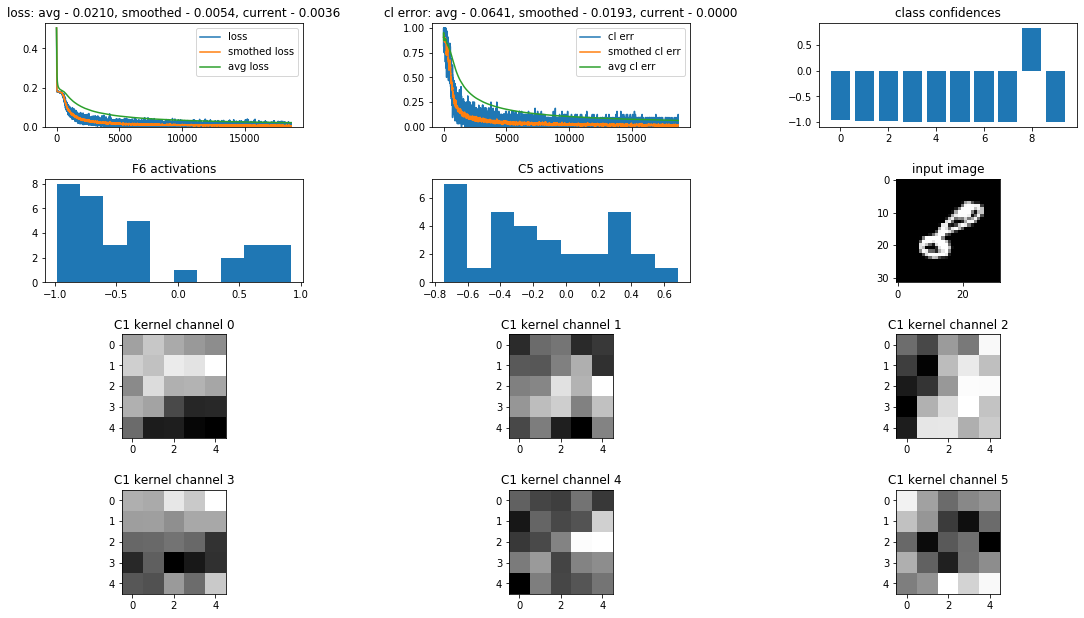

2.887881278991699 seconds per 100 iterations


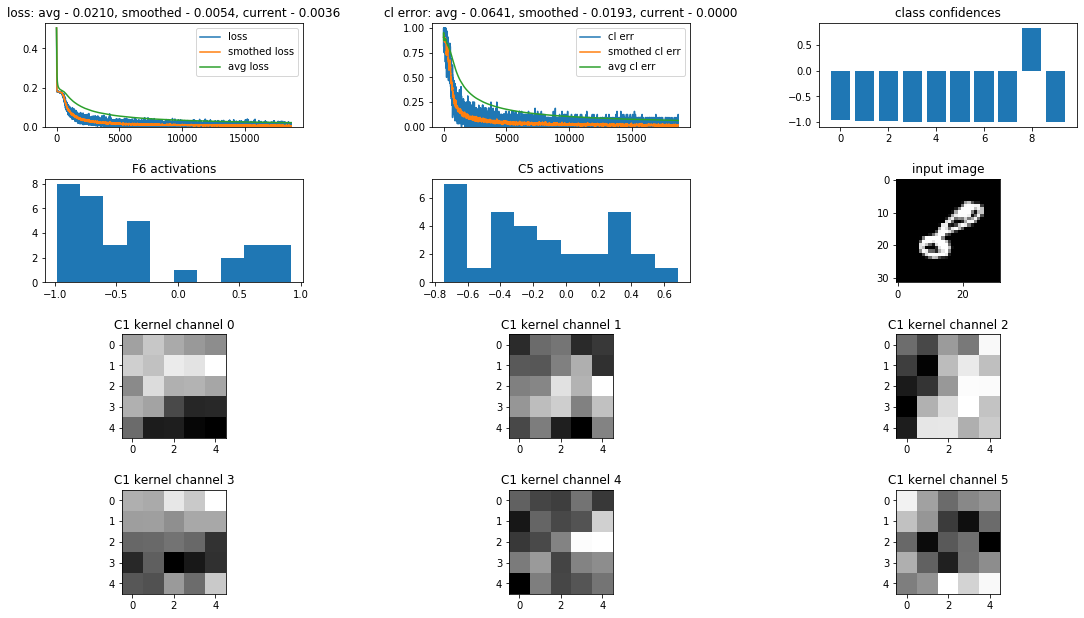

In [8]:
ntrain = trainimages.shape[0];  # number of training examples
nepoch = 10;                    # number of epochs through training set
disp_freq = 100                 # display frequency
batchsize = 32                  # minibatch size

errs = []
losses = []

lenet5 = LeNet5()

# use SGD optimizer, set learning rate parameter as 0.1
optimizer = optim.SGD(lenet5.parameters(), lr=0.1)

t_start = time.time()
for iepoch in range(nepoch):
    for t in range(int(ntrain / batchsize)):
        batchindices = np.random.choice(ntrain, batchsize, replace=False)
        trainlabels_iter = trainlabels[batchindices]
        
        # label 1 for the correct digit and -1 for the incorrect digits
        y = torch.ones(10, batchsize) * (-1)
        y[trainlabels_iter, torch.arange(batchsize, dtype=torch.int64)] = 1

        # normalize input images
        imgs = torch.zeros([batchsize, 1, 32, 32])
        imgs[:, 0, 2: -2, 2: -2] = trainimages[batchindices].float() / 255.

        # before the forward pass, clean the gradient buffers of all parameters
        optimizer.zero_grad()

        # forward pass
        out = lenet5(imgs)
        
        # MSE loss
        loss = torch.mean(0.5*(y - out.t())**2)

        # backward pass
        loss.backward()

        # update parameters using SGD
        optimizer.step()

        # calculate error rate and loss for plot
        pred = torch.argmax(out, dim=1)
        err = torch.mean((pred != trainlabels_iter).float())
        errs.append(err.detach().numpy())
        losses.append(loss.detach().numpy())

        
        # plots
        if (t + 1) % disp_freq == 0:
            plt.gcf().clear()
            visualize(len(errs) - 1, losses, errs, out[0,:].detach(), lenet5.record["F6"][:, 0], 
                      lenet5.record["C5"][:, 0], imgs[0, 0].detach(), lenet5.C1.weight.detach().squeeze())
            print(str(time.time() - t_start) + " seconds per " + str(disp_freq) + " iterations")
            t_start = time.time()
            time.sleep(0.01)

### Use ReLU activation and change C5 to F5
Now let's implement a varant of LeNet-5, use `ReLU` activation function instead of `tanh` activation function for each layer. And change the convolutional layer C5 in the original net work to a fully connected layer F5. You will have to use softmax as the network output. 

In [9]:
class LeNet5_Relu(nn.Module):

    # definition of each neural network layer
    def __init__(self):
        super(LeNet5_Relu, self).__init__()
        self.C1 = nn.Conv2d(1, 6, kernel_size=(5, 5))
        self.S2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.C3 = nn.Conv2d(6, 16, kernel_size=(5, 5))
        self.S4 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        
        ####### Complete the defition of F5 #################
        
        self.F5 = nn.linear(16,120)    
        
        #####################################################

        self.F6 = nn.Linear(120, 84)

        # output layer
        self.OL = nn.Linear(84, 10)
        
        # record C5 & C6 activation for visualization
        self.record = {"F5":None, "F6":None}

    # definition of the forward pass
    def forward(self, x):
        
        ####### Complete the foward pass C1 >> F5 ##########
        
        x = torch.tanh(self.C1(x))
        x = self.S2(x)
        x = torch.tanh(self.C3(x))
        x = self.S4(x)
        x = functional.relu(self.F5(x))
        x = x.view(x.size(0), -1)      
        
        #####################################################

        self.record["F5"] = x.clone().detach().numpy()
        x = torch.relu(self.F6(x))
        self.record["F6"] = x.clone().detach().numpy()
        x = functional.softmax(self.OL(x), dim=1)
        
        return x